# Quickstart

Check out https://trak.readthedocs.io/en/latest/quickstart.html

## Train and save model checkpoints

In [1]:
import os
from pathlib import Path
import wget
from tqdm.auto import tqdm
import numpy as np
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss, Conv2d, BatchNorm2d
from torch.optim import SGD, lr_scheduler
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Resnet9
class Mul(torch.nn.Module):
    def __init__(self, weight):
        super(Mul, self).__init__()
        self.weight = weight
    def forward(self, x): return x * self.weight


class Flatten(torch.nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module
    def forward(self, x): return x + self.module(x)


def construct_rn9(num_classes=10):
    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1):
        return torch.nn.Sequential(
                torch.nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size,
                            stride=stride, padding=padding, groups=groups, bias=False),
                torch.nn.BatchNorm2d(channels_out),
                torch.nn.ReLU(inplace=True)
        )
    model = torch.nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
        Residual(torch.nn.Sequential(conv_bn(128, 128), conv_bn(128, 128))),
        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        Residual(torch.nn.Sequential(conv_bn(256, 256), conv_bn(256, 256))),
        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        torch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        torch.nn.Linear(128, num_classes, bias=False),
        Mul(0.2)
    )
    return model

In [3]:
def get_dataloader(batch_size=256, num_workers=8, split='train', shuffle=False, augment=True):
    if augment:
        transforms = torchvision.transforms.Compose(
                        [torchvision.transforms.RandomHorizontalFlip(),
                         torchvision.transforms.RandomAffine(0),
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])
    else:
        transforms = torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])
        
    is_train = (split == 'train')
    dataset = torchvision.datasets.CIFAR10(root='/tmp/cifar/',
                                           download=True,
                                           train=is_train,
                                           transform=transforms)

    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         shuffle=shuffle,
                                         batch_size=batch_size,
                                         num_workers=num_workers)
    
    return loader

In [4]:
def train(model, loader, lr=0.4, epochs=24, momentum=0.9,
          weight_decay=5e-4, lr_peak_epoch=5, label_smoothing=0.0):
    
    opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    iters_per_epoch = len(loader)
    # Cyclic LR with single triangle
    lr_schedule = np.interp(np.arange((epochs+1) * iters_per_epoch),
                            [0, lr_peak_epoch * iters_per_epoch, epochs * iters_per_epoch],
                            [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(opt, lr_schedule.__getitem__)
    scaler = GradScaler()
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    for ep in range(epochs):
        for it, (ims, labs) in enumerate(loader):
            ims = ims.cuda()
            labs = labs.cuda()
            opt.zero_grad(set_to_none=True)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()

    return model

In [5]:
os.makedirs('./checkpoints', exist_ok=True)
loader_for_training = get_dataloader(batch_size=512, split='train', shuffle=True)

for i in tqdm(range(10), desc='Training models..'):
    model = construct_rn9().to(memory_format=torch.channels_last).cuda()
    model = train(model, loader_for_training)
    torch.save(model.state_dict(), f'./checkpoints/sd_{i}.pt')

Files already downloaded and verified


Training models..:   0%|          | 0/10 [00:00<?, ?it/s]

### Make a list of checkpoints

In [6]:
ckpt_files = sorted(list(Path('./checkpoints').rglob('*.pt')))
ckpts = [torch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

### Check test accuracy

In [7]:
model = construct_rn9().to(memory_format=torch.channels_last).cuda()
model.load_state_dict(ckpts[0])
model = model.eval()

In [8]:
loader = get_dataloader(split='val', augment=False)
model.eval()

with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loader):
        ims = ims.cuda()
        labs = labs.cuda()
        with autocast():
            out = model(ims)
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

Files already downloaded and verified


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 91.5%


## Set up the TRAKer class

In [9]:
batch_size = 128
loader_train = get_dataloader(batch_size=batch_size, split='train')

Files already downloaded and verified


In [10]:
from trak import TRAKer

traker = TRAKer(model=model,
                task='image_classification',
                proj_dim=4096,
                train_set_size=len(loader_train.dataset))

Existing IDs in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results: []


## Compute TRAK features for train data

In [11]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.load_checkpoint(ckpt, model_id=model_id)
    for batch in tqdm(loader_train):
        batch = [x.cuda() for x in batch]
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

traker.finalize_features()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 10/10 [03:28<00:00, 20.89s/it]


## Compute TRAK scores for targets

In [12]:
loader_targets = get_dataloader(batch_size=batch_size, split='val', augment=False)

Files already downloaded and verified


In [13]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.start_scoring_checkpoint(ckpt,
                                    model_id=model_id,
                                    num_targets=len(loader_targets.dataset))
    for batch in loader_targets:
        batch = [x.cuda() for x in batch]
        traker.score(batch=batch, num_samples=batch[0].shape[0])

scores = traker.finalize_scores()

  0%|          | 0/10 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Saving scores in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results/scores/scores_32d1d93e-9a0a-48c5-83de-7464a8e07ac5.npy


## Visualize TRAK scores

In [19]:
from matplotlib import pyplot as plt

In [15]:
ds_train = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=True)
ds_val = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


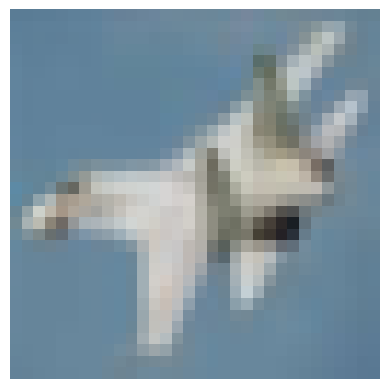

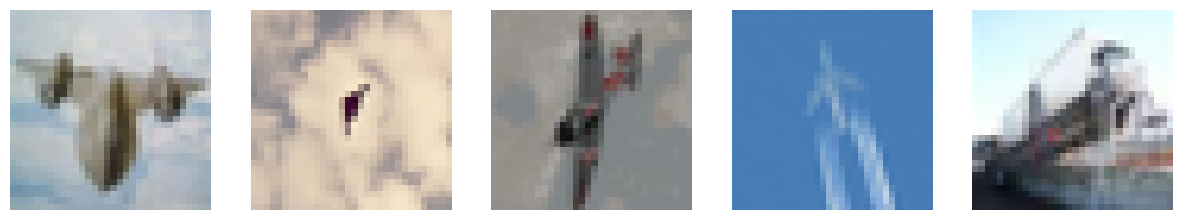

In [18]:
i = 10
plt.imshow(ds_val[i][0]); plt.axis('off'); plt.show()
top_trak_scorers = scores[:, i].argsort()[-5:].cpu().numpy()[::-1]

fig, axs = plt.subplots(ncols=5, figsize=(15, 3))
for ii, train_im_ind in enumerate(top_trak_scorers):
    axs[ii].imshow(ds_train[train_im_ind][0]); axs[ii].axis('off')

## Bonus: evaluate counterfactuals

We exactly follow the steps in https://docs.ffcv.io/ffcv_examples/cifar10.html. Additionally, we train on *subsets* of CIFAR-10, parametrized by the `masks` arrays below. We collect the model outputs for each retraining on a different subset (mask) in a separate array `margins`.

We train a total of 10,000 models. Note that this is not necessary to get TRAK scores. This step is only necessary to get (very high quality) LDS correlation estimates.

In [20]:
from scipy.stats import spearmanr

In [21]:
def eval_correlations(scores, tmp_path):    
    masks_url = '/url/to/masks'  # dropbox link coming soon
    margins_url = '/url/to/margins'

    masks_path = Path(tmp_path).joinpath('mask.npy')
    wget.download(masks_url, out=str(masks_path), bar=None)
    # num masks, num train samples
    masks = torch.as_tensor(np.load(masks_path, mmap_mode='r')).float()
    
    margins_path = Path(tmp_path).joinpath('val_margins.npy')
    wget.download(margins_url, out=str(margins_path), bar=None)
    # num , num val samples
    margins = torch.as_tensor(np.load(margins_path, mmap_mode='r'))

    val_inds = np.arange(10_000)
    preds = masks @ scores
    rs = []
    ps = []
    for ind, j in tqdm(enumerate(val_inds)):
        r, p = spearmanr(preds[:, ind], margins[:, j])
        rs.append(r)
        ps.append(p)
    rs, ps = np.array(rs), np.array(ps)
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean()})')
    return rs.mean()

In [22]:
corr = eval_correlations(scores.cpu(), '.')

0it [00:00, ?it/s]

Correlation: 0.127 (avg p value 0.00012112002481238829)
